# Phylogeny of 13 ray-finned fish based on gene order data

This notebook documents the code and procedure we used to establish the **gene-order-based phylogeny of ray-finned fish** presented in the **[the bowfin genome paper](https://www.researchsquare.com/article/rs-92055/v1)**. This phylogeny supports the **Holostei hypothesis** of ray-finned fish evolution, which defines **the bowfin and spotted gar as sister groups**. The notebook is a mixed-languages jupyter notebook including both **python and R** code.

# Table of contents

- [Libraries and packages](#libraries-and-packages)
    - [External dependencies](#external-dependencies)
    - [Custom python modules](#custom-python-modules)
- [Input data description](#input-data-description)
- [Gene order phylogeny](#gene-order-phylogeny)
    - [Marker genes selection](#marker-genes-selection)
    - [Adjacencies extraction](#adjacencies-extraction)
    - [Distance matrix computation](#distance-matrix-computation)
    - [Neighbor-joining tree reconstruction](#neighbor-joining-tree-reconstruction)
    - [Bootstrap support](#bootstrap-support)
    - [Branch length differences](#brlen)
- [Maximum parsimony gene order phylogeny](#gene-order-phylogeny-pars)


## Libraries and packages <a name="libraries-and-packages"></a>

All external dependencies to run the notebook are listed in the `binder/environment.yml` file, which includes both python packages and R libraries. Custom python modules are also stored in the `modules/` folder.

### External dependencies <a name="external-dependencies"></a>

In [1]:
#Standard imports
import os
import itertools
import glob
import bz2
from collections import defaultdict

#Uncomment to fix a random seed (can be useful for bootstrap)
import random
random.seed(400)

In [2]:
#Gene tree manipulation
from Bio import Phylo
from Bio.Phylo.Consensus import majority_consensus,get_support
from ete3 import Tree, NodeStyle, TreeStyle,TextFace, AttrFace,faces

In [3]:
#Data loading and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")

In [4]:
#Use R in python
%load_ext rpy2.ipython

### Custom python modules <a name="custom-python-modules"></a>

In [5]:
#Load my python code
%run modules/genomes.py
%run modules/adjacencies.py
%run modules/matrix.py
%run modules/bootstrap.py

## Input data description  <a name="input-data-description"></a>

All input data are stored in `data/gene_order_phylogeny/`.

It includes an `ancGenes` file defining **gene families**, and files with **gene coordinates**, both in the **dyogen format**. Briefly, gene families were defined from gene trees built with the TreeBeST pipeline, including a total of 78 genomes and 55 ray-finned fish (*internally designated as GoodThreshold Genomicus V2 data*). In what follows, a subset of the gene families, containing the **13 selected ray-finned fish** and **2 outgroups** (chicken and xenopus) is extracted. This dataset is then used for all analyses.

In [6]:
%%bash
tree data/gene_order_phylogeny/

data/gene_order_phylogeny/
├── ancGenes.Euteleostomi.list.bz2
├── genes.Amia.calva.list.bz2
├── genes.Astyanax.mexicanus.list.bz2
├── genes.Danio.rerio.list.bz2
├── genes.Gallus.gallus.list.bz2
├── genes.Gasterosteus.aculeatus.list.bz2
├── genes.Lepisosteus.oculatus.list.bz2
├── genes.Oreochromis.niloticus.list.bz2
├── genes.Oryzias.latipes.list.bz2
├── genes.Paramormyrops.kingsleyae.list.bz2
├── genes.Poecilia.formosa.list.bz2
├── genes.Scleropages.formosus.list.bz2
├── genes.Takifugu.rubripes.list.bz2
├── genes.Tetraodon.nigroviridis.list.bz2
├── genes.Xenopus.tropicalis.list.bz2
└── genes.Xiphophorus.maculatus.list.bz2

0 directories, 16 files


Define global variables for paths to input data:

In [7]:
FAMILIES = "data/gene_order_phylogeny/ancGenes.Euteleostomi.list.bz2"
GENES = "data/gene_order_phylogeny/genes.%s.list.bz2"

## Gene order phylogeny <a name="gene-order-phylogeny"></a>

The gene order phylogeny is built in 5 steps detailed below. First, a **selection of marker genes** is conducted to limit the effect of differential gene content. The genomes are then reduced to these marker genes and **gene adjacencies** are stored. Next, a **distance matrix** then a **neighbor-joining tree** are built. Finally, **bootstrap** is perfomed to add support to nodes of the phylogeny.

*Note: the code below writes a lot of intermediary files that may seem unnecessary. These were initally used for additional unpublished controls and analyses.*

All outputs are stored in `output/`.

In [8]:
os.makedirs("output", exist_ok=True)

### Marker genes selection <a name="marker-genes-selection"></a>

Because the selected species contain teleost species that underwent a common whole-genome duplication event, we retained only gene families with exactly one gene copy in non-duplicated genomes and one or two gene copies in duplicated genomes. Corresponding custom functions can be found in `modules/genomes.py`.

In [9]:
# global variable with all species name
ALL_SPECIES = ['Gallus gallus','Xenopus tropicalis','Lepisosteus oculatus', 'Amia calva', 'Paramormyrops kingsleyae','Scleropages formosus', 'Astyanax mexicanus','Danio rerio','Gasterosteus aculeatus', 'Tetraodon nigroviridis', 'Takifugu rubripes', 'Oreochromis niloticus', 'Oryzias latipes', 'Poecilia formosa', 'Xiphophorus maculatus']

#global variable with latin to common name correspondance (for plots)
SP_DICT = {'Gallus':'Chicken', 'Xenopus':'Xenopus', 'Lepisosteus':'Gar', 'Amia':'Bowfin', 'Paramormyrops':'Paramormyrops', 'Scleropages':'Asian bonytongue', 'Astyanax':'Cavefish', 'Danio':'Zebrafish', 'Gasterosteus':'Stickleback', 'Tetraodon':'Tetraodon', 'Takifugu':'Fugu', 'Oreochromis':'Tilapia', 'Oryzias':'Medaka', 'Poecilia':'Amazon molly', 'Xiphophorus':'Platyfish'}

# global variable with name of non-duplicated species (non-teleost)
NON_DUP = ['Lepisosteus oculatus', 'Amia calva', 'Gallus gallus', 'Xenopus tropicalis']

# Build a dict containing genes of all study species
all_sp_genes, genes_on_random_contig = {}, set()
for sp in ALL_SPECIES:
    sp = sp.replace(' ','.')
    genefile = GENES % (sp)
    all_sp_genes[sp], tmp_genes_on_random_contig = extract_all_genes(genefile)
    genes_on_random_contig.update(tmp_genes_on_random_contig)

In [10]:
# Filter gene families to retain (1-to-1 or 1-to-2 for duplicated species)
filter_families(all_sp_genes, NON_DUP, 'data/gene_order_phylogeny/ancGenes.Euteleostomi.list.bz2', 'output/ancGenes.Euteleostomi.filtered')

Number of marker gene families selected: 3223.
Number of corresponding genes in each species: {'Gallus.gallus': 3223, 'Xenopus.tropicalis': 3223, 'Lepisosteus.oculatus': 3223, 'Amia.calva': 3223, 'Paramormyrops.kingsleyae': 4067, 'Scleropages.formosus': 4039, 'Astyanax.mexicanus': 3765, 'Danio.rerio': 3721, 'Gasterosteus.aculeatus': 3607, 'Tetraodon.nigroviridis': 3713, 'Takifugu.rubripes': 3683, 'Oreochromis.niloticus': 3659, 'Oryzias.latipes': 3604, 'Poecilia.formosa': 3851, 'Xiphophorus.maculatus': 3601}


In [11]:
# Write reduced genomes, i.e. containing only retained families, in fasta format
name_families, unRAND = read('output/ancGenes.Euteleostomi.filtered', genes_on_random_contig) 
write_genomes(name_families, GENES, ALL_SPECIES, 'output/mygenomes.fa')

At the end of this step, the file `output/mygenomes.fa` stores marker gene order in the 15 selected species.

### Adjacencies extraction <a name="adjacencies-extraction"></a>

This step consists in a simple parsing of the multiple genomes fasta file, to extract sets of **gene adjacencies** present in each species. Corresponding custom functions can be found in `modules/adjacencies.py`.

In [12]:
#Load genomes in a dict
d_seq = load_genomes("output/mygenomes.fa")

**First pass extraction**

In [13]:
#Save all adjacencies for all species and in each direction. For instance, (-1,2) is equivalent to (-2,1).
adj_list, adj_list_rev = save_all_adj(d_seq)

**Final extraction** : filter out tetraodon adjacencies on random contig that are in no other species (UnRandom is a contig with all scaffolds chained in a random order).

In [14]:
#Write adjacencies in a binary absence/presence matrix and filter tetraodon adjacencies (save them in 'to_ign')
all_adj, to_ign = make_binary_adj_matrix(adj_list, adj_list_rev, ALL_SPECIES, unrandom=unRAND, sp_with_rm="Tetraodon nigroviridis")

#Also filter out tetraodon adjacencies from the adjacencies dict
adj_list, adj_list_rev = save_all_adj(d_seq, to_ignore=to_ign, sp_with_ign="Tetraodon nigroviridis")

Number of total adjacencies: 16561
Number of derived adjacencies shared only by Bowfin and Gar: 372
Number of derived adjacencies shared by Bowfin and Teleosts only: 108
Number of derived adjacencies shared by Gar and Teleosts only: 86


The dictionnaries `adj_list` and `adj_list_rev` store the complete sets of gene adjacencies in each species, while `all_adj` stores it in a binary absence/presence matrix.

### Distance matrix computation <a name="distance-matrix-computation"></a>

Corresponding custom functions for this part can be found in `modules/matrix.py`.

Two strategies can be used to compute the pairwise distance :
 - the 'simple' normalized breakpoint distance
 - the normalized breakpoint distance corrected for post-WGD fractionation (massive gene losses disturbing adjacencies)
 
The normalized breakpoint distance NBD is computed as follows : NBD = (1 - proportion of shared adjacencies). The correction for disruption of adjacencies through gene losses considered relaxed adjacencies between duplicated and non-duplicated species (see the documentation of `correct_frac_bias` in `modules/matrix.py`).

You can select the strategy below:

In [15]:
CORRECT_FOR_FRAC_BIAS = False #set to True to use the correction for post-WGD fractionation

Next, we compute all pairwise distances and build the distance matrix. 

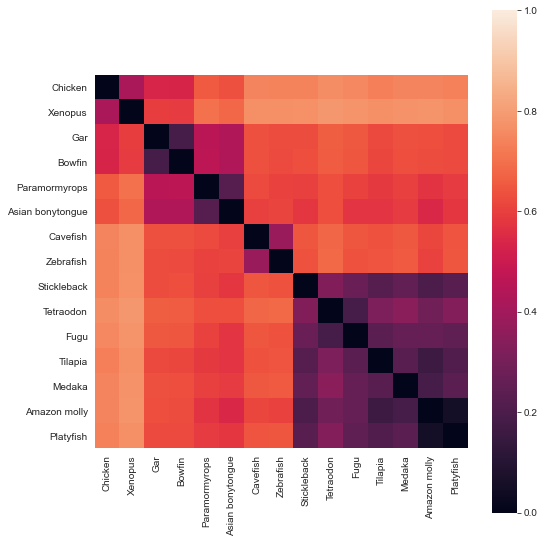

In [16]:
if CORRECT_FOR_FRAC_BIAS:
    correct_frac_bias(adj_list, adj_list_rev, ALL_SPECIES, d_seq, NON_DUP) #not optimized, may take ~1min

# build the distance matrix, plot it, and write it to file 'output/dist_mat'
make_distance_matrix(adj_list, adj_list_rev, SP_DICT, ALL_SPECIES)

The file `output/dist_mat` stores the computed distance matrix.

### Neighbor-joining tree reconstruction <a name="neighbor-joining-tree-reconstruction"></a>

Use the `ape` R library to build a neighbor-joining tree from the distance matrix.

In [17]:
%%R 
library('ape')

tree_methods <- function(dist.mat, method=c("NJ", "FASTME", "UPGMA")){
    
    method <- match.arg(method)
    
    #build tree
    if (method == "NJ"){
        tree <- bionj(dist.mat)
    }
    
    if (method == "FASTME"){
        tree <- fastme.bal(dist.mat)
        tree <- root(tree, outgroup=c('Xenopus', 'Chicken'), resolve.root=TRUE) # root using the outgroups
    }
    
    if (method == "UPGMA"){
        dist.mat <- as.dist(dist.mat)
        tree <- as.phylo(hclust(dist.mat, "average")) # upgma() in phangorn 
    }
    return(tree)
}

In [18]:
%%R
library('ape')

build_tree <- function(method=c("NJ", "FASTME", "UPGMA")){

    method <- match.arg(method)
    
    #reformat the distance matrix
    dist.mat <- read.table('output/dist_mat', header = TRUE, sep = "", skip = 0)
    rownames(dist.mat) <- colnames(dist.mat)
    dist.mat <- as.matrix(dist.mat)

    tree <- tree_methods(dist.mat, method)
    
    outfile <- paste('output/', method, '.nwk', sep='')
    
    write.tree(tree, file=outfile)
    
    if (method == 'NJ'){
        tree <- root(tree, outgroup=c('Xenopus', 'Chicken'), resolve.root=TRUE) # root using the outgroups
    }
    plot(tree, "phylo") # we plot it, unrooted
    nodelabels()
    
}

In [19]:
METHOD = 'NJ' #can be one of NJ, FASTME or UPGMA

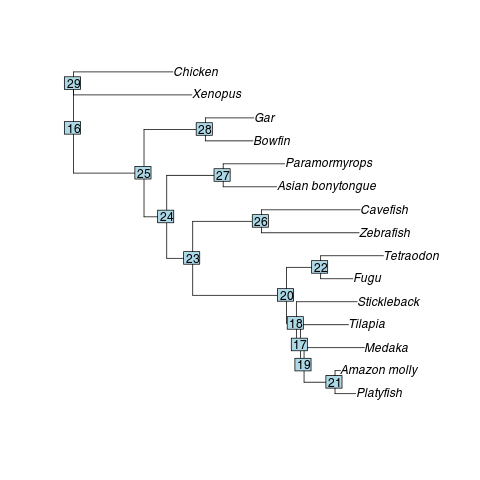

In [20]:
%%R -i METHOD
build_tree(METHOD)

The file `output/output/bionj.nwk` stores the neighbor-joining tree.

### Bootstrap support  <a name="bootstrap-support"></a>

- Generate 100 bootstrap replicates of the binary absence/presence adjacency matrix and compute a distance matrix for each.

In [21]:
bootstrap_matrix(all_adj, ALL_SPECIES, SP_DICT)

10 bootstrap replicates done
20 bootstrap replicates done
30 bootstrap replicates done
40 bootstrap replicates done
50 bootstrap replicates done
60 bootstrap replicates done
70 bootstrap replicates done
80 bootstrap replicates done
90 bootstrap replicates done
100 bootstrap replicates done
DONE


- Build a tree for each replicate

In [22]:
%%R 
library('ape') 

boot_tree <- function(method=c("NJ", "FASTME", "UPGMA")){
    dist.mat <- read.table('output/dist_mat', header = TRUE, sep = "", skip = 0)

    # load distance matrix of bootstrap replicates and build trees
    for (i in 0:99){
      infile = paste('output/bootstrap/dist_mat_', as.character(i), '.txt', sep='')
      outfile = paste('output/bootstrap/', method, '_', as.character(i), '.nwk', sep='')
      dist.mat <- read.table(infile, header = TRUE, sep = "", skip = 0)
      rownames(dist.mat) <- colnames(dist.mat)
      dist.mat <- as.matrix(dist.mat)
        
      # neighbour joining tree construction for each bootstrap replicate and write to file
      tree <- tree_methods(dist.mat, method)
      write.tree(tree, file=outfile)
    }
}

In [23]:
%%R -i METHOD
boot_tree(METHOD)

- Add bootstrap support and store branch length difference for a selection of species pair

In [24]:
SPECIES_PAIRS = [('Bowfin', 'Gar'), ('Bowfin', 'Zebrafish'), ('Bowfin', 'Fugu'), ('Bowfin', 'Asian_bonytongue')]

In [25]:
bstrap = glob.glob(f'output/bootstrap/{METHOD}_*.nwk')
tree = f'output/{METHOD}.nwk'
brlen_diff = add_bootstrap_support(tree, bstrap, branch_length_diff=SPECIES_PAIRS)

- Plot the phylogeny

In [26]:
def layout(node):
    if node.is_leaf():
        N = AttrFace("name", fsize=9)
        faces.add_face_to_node(N, node, 0)
        
        
def draw_tree(tree, outfile):
    
    """
    SVG figure of the final tree with bootstrap support.
    """
    
    tree = Tree(tree)
    ts = TreeStyle()
    lca = tree.get_common_ancestor(['Bowfin', 'Gar'])
    for n in tree.traverse():

        nstyle = NodeStyle()
        nstyle['size'] = 0

        if n == lca or n.name in ['Bowfin', 'Gar']:

            nstyle['bgcolor'] = 'pink'

        else:
            nstyle['bgcolor'] = 'white'

        if n.name in ['Stickleback']:
            nstyle["hz_line_color"] = "grey"
            nstyle["hz_line_width"] = 2

        n.set_style(nstyle)

    ts.show_leaf_name = False
    ts.layout_fn = layout
    ts.show_branch_support = True
    ts.tree_width = 300
    tree.render(outfile, dpi=80, tree_style=ts)
    plt.close("all")

In [27]:
draw_tree('output/ete3_formatted_bootstrap_tree.nwk', f'output/{METHOD}_tree.svg')

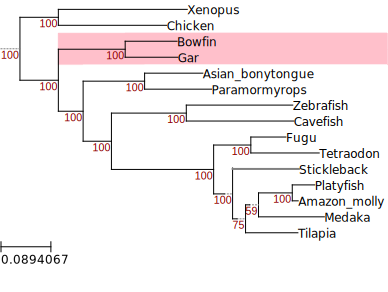

In [28]:
from IPython.core.display import SVG
SVG(filename=f'output/{METHOD}_tree.svg')

### Branch length differences  <a name="brlen"></a>

Here we'll used the stored branch length differences extracted from bootstraped trees to compute the 95% bootstrap intervals.

In [29]:
for sp_pair in brlen_diff:
    diff_bl = brlen_diff[sp_pair]
    lval = np.percentile(diff_bl, (0.05 / 2) * 100)
    uval = np.percentile(diff_bl, (0.95 + (0.05 / 2)) * 100)
    print(f'95% bootstrap interval for branch {sp_pair[0]} - branch {sp_pair[1]} :')
    print([lval, uval])
    if lval < 0 and uval > 0:
        print("Bootstrap interval includes 0 : no significant difference.")
    elif lval < 0:
        print(f"{sp_pair[1]} has a significantly longer branch length than {sp_pair[0]}.")
    else:
        print(f"{sp_pair[0]} has a significantly longer branch length than {sp_pair[1]}.")
        
    print('\n')

95% bootstrap interval for branch Bowfin - branch Gar :
[-0.008934080599999991, 0.005466774100000009]
Bootstrap interval includes 0 : no significant difference.


95% bootstrap interval for branch Bowfin - branch Zebrafish :
[-0.22521869285999999, -0.19496279955999996]
Zebrafish has a significantly longer branch length than Bowfin.


95% bootstrap interval for branch Bowfin - branch Fugu :
[-0.22475875353000002, -0.19891703313999995]
Fugu has a significantly longer branch length than Bowfin.


95% bootstrap interval for branch Bowfin - branch Asian_bonytongue :
[-0.06385375181500003, -0.035687450344999996]
Asian_bonytongue has a significantly longer branch length than Bowfin.




## Maximum parsimony gene order phylogeny <a name="gene-order-phylogeny-pars"></a>

Just explain and compute HKY tests